In [173]:
import glob

import unicodedata
import string

import torch
import torch.nn as nn
from torch.autograd import Variable

import time 
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import random

In [2]:
all_filenames = glob.glob('data/names/*.txt')

In [3]:
#Convert unicode to plain ASCII
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [4]:
category_lines = {}
all_categories = []

In [5]:
def read_names(filename):
    names = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(name) for name in names]
    

In [6]:
for filename in all_filenames:
    lang_name = filename.split('/')[-1].split('.')[0]
    all_categories.append(lang_name)
    names = read_names(filename)
    category_lines[lang_name] = names
    
n_categories = len(all_categories)

In [7]:
print(f'lenght of categories {len(all_categories)}')

lenght of categories 18


In [8]:
n_letters

57

In [9]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [10]:

def letter_to_tensor(char):
    tensor = torch.zeros(1,n_letters)
    char_index = all_letters.find(char)
    tensor[0][char_index] = 1
    return tensor


In [11]:
line = 'ab'
def line_to_tensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li,char in enumerate(line):
        char_index = all_letters.find(char)
        tensor[li][0][char_index] = 1
    return tensor


In [12]:
line_to_tensor('vishnu').size()

torch.Size([6, 1, 57])

In [13]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax()
        
        
    def forward(self,input,hidden):
        comined = torch.cat((input,hidden),1)
        hidden = self.i2h(comined)
        output = self.i2o(comined)
        output = self.softmax(output)
        return output,hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1,self.hidden_size))
        
        

In [14]:
n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

In [23]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self,input,hidden):
        x = torch.cat((input,hidden),1)
        hidden = self.i2h(x)
        output = self.i2o(x)
        output = self.softmax(output)
        return output,hidden

    def init_hidden(self):
        return Variable(torch.zeros(1,hidden_size))
        

In [25]:
hidden_size = 128
rnn = RNN(n_letters,hidden_size,n_categories)

In [26]:
inp = Variable(letter_to_tensor('A'))
hidden = Variable(torch.zeros(1,hidden_size))
outp, hidd = rnn(inp,hidden)

In [27]:
outp

Variable containing:

Columns 0 to 9 
-2.8384 -2.8594 -2.8318 -2.9425 -2.8495 -3.0024 -2.9488 -2.9040 -2.8713 -2.8250

Columns 10 to 17 
-2.9511 -2.9021 -2.8140 -2.8510 -2.8696 -2.8828 -2.9927 -2.9176
[torch.FloatTensor of size 1x18]

In [31]:
rnn = RNN(n_letters,hidden_size,n_categories)
inp = Variable(line_to_tensor('vishnu'))
hidn = rnn.init_hidden()
outp , hidn = rnn(inp[0],hidn)

In [32]:
outp

Variable containing:

Columns 0 to 9 
-2.8429 -2.8123 -2.8792 -3.0119 -3.0048 -2.7906 -2.9181 -2.9575 -2.9096 -2.9872

Columns 10 to 17 
-2.8065 -2.9128 -2.8506 -2.8873 -2.9174 -2.8488 -2.9212 -2.8080
[torch.FloatTensor of size 1x18]

In [33]:
n_categories

18

In [39]:
top_v,top_i = outp.data.topk(1)

In [40]:
top_i


 5
[torch.LongTensor of size 1x1]

In [43]:
all_letters[top_i[0][0]]

'f'

In [44]:
def category_from_tensor(output):
    top_v,top_i = output.data.topk(1)
    category_index = top_i[0][0]
    category = all_categories[category_index]
    return category,category_index

In [45]:
category_from_tensor(outp)

('Arabic', 5)

In [50]:
category = random.choice(all_categories)

In [51]:
line = random.choice(category_lines[category])

In [52]:
line

'Yasutake'

In [55]:
Variable(torch.LongTensor([all_categories.index(category)]))

Variable containing:
 13
[torch.LongTensor of size 1]

In [56]:
def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category,line,category_tensor,line_tensor

In [57]:
for i in range(10):
    category,line,category_tensor,line_tensor = random_training_pair()
    print(f'category = {category} / line = {line}')

category = English / line = Anscombe
category = Russian / line = Mulyukov
category = Polish / line = Starek
category = English / line = Kennell
category = Polish / line = Zdunowski
category = Vietnamese / line = Vo
category = Greek / line = Tsahalis
category = English / line = Reade
category = Russian / line = Awtandiloff
category = Scottish / line = Wallace


In [63]:
criterion = nn.NLLLoss()

In [66]:
learning_rate = 0.0005
optimizer = torch.optim.SGD(params= rnn.parameters(),lr=learning_rate)

In [69]:
def train(category_tensor,line_tensor):
    rnn.zero_grad()
    hidden = Variable(torch.zeros(1,hidden_size))
    for i in range(line_tensor.size()[0]):
        outp,hidden = rnn(line_tensor[i],hidden)
    loss = criterion(outp,category_tensor)
    loss.backward()
    optimizer.step()
    return outp,loss.data[0]
    
    

In [166]:
n_epochs = 100000
print_every = 5000
plot_every = 1000

In [167]:
current_loss = 0
all_losses = []

In [168]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return f'{m}m {round(s)}s'

In [170]:
start = time.time()
for epoch in range(1,n_epochs + 1):
    category,line,category_tensor,line_tensor = random_training_pair()
    output,loss = train(category_tensor,line_tensor)
    current_loss += loss
    
    if epoch % print_every == 0:
        guess , guess_i = category_from_tensor(output)
        correct = '✓' if guess == category else f'✗ {category}' 
        print(f'{epoch},{(epoch/n_epochs)*100}% , {time_since(start)} , {loss:{2}.{4}} , {line} / {guess} {correct} ')
        
    if epoch % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0
        

5000,5.0% , 0m 10s , 2.584 , Murphy / English ✗ Irish 
10000,10.0% , 0m 20s , 2.295 , Hartl / Arabic ✗ Czech 
15000,15.0% , 0m 30s , 2.172 , Felix / French ✓ 
20000,20.0% , 0m 40s , 2.608 , Uhlik / Korean ✗ Czech 
25000,25.0% , 0m 51s , 1.709 , Cabello / Italian ✗ Spanish 
30000,30.0% , 1m 1s , 2.291 , Bonnet / Dutch ✗ French 
35000,35.0% , 1m 11s , 2.881 , Ross / Portuguese ✗ Scottish 
40000,40.0% , 1m 21s , 4.417 , Close / French ✗ Greek 
45000,45.0% , 1m 31s , 2.674 , Bowes / Dutch ✗ English 
50000,50.0% , 1m 41s , 2.175 , Machado / Japanese ✗ Portuguese 
55000,55.00000000000001% , 1m 51s , 1.377 , An / Korean ✗ Vietnamese 
60000,60.0% , 2m 2s , 0.3375 , Okanaya / Japanese ✓ 
65000,65.0% , 2m 12s , 0.5249 , Yeon / Korean ✓ 
70000,70.0% , 2m 22s , 1.211 , Riain / Irish ✓ 
75000,75.0% , 2m 32s , 1.083 , Meeuwessen / German ✗ Dutch 
80000,80.0% , 2m 42s , 1.773 , Swatchak / Polish ✗ Czech 
85000,85.0% , 2m 52s , 1.325 , Hong / Chinese ✗ Korean 
90000,90.0% , 3m 2s , 1.302 , Campos / Po

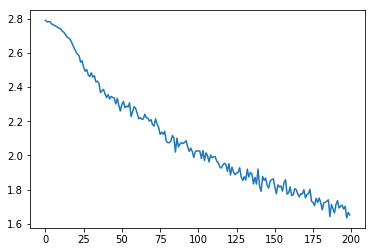

In [174]:
plt.figure()
plt.plot(all_losses)

In [184]:
confusion = torch.zeros(n_categories,n_categories)
n_confusion = 10000

In [187]:
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    return output

In [188]:
for i in range(n_confusion):
    category,line,category_tensor,line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess,guess_i = category_from_tensor(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    

In [189]:
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()

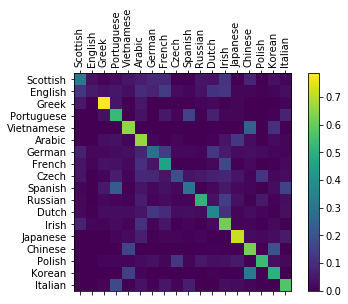

In [200]:


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels(['']+all_categories,rotation=90)
ax.set_yticklabels(['']+all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [209]:
def predict(input_line,n_predictions=3):
    line_tensor = Variable(line_to_tensor(input_line))
    output = evaluate(line_tensor)
    top_v,top_i = output.data.topk(3,1)
    for i in range(n_predictions):
        category = all_categories[top_i[0][i]]
        print(f'{top_v[0][i]} category is {category}')
        

In [210]:
predict('Vishnu')

-1.2183682918548584 category is Vietnamese
-2.446791410446167 category is Japanese
-2.478475570678711 category is Irish


In [211]:
predict('Achillios')

-0.20106391608715057 category is Greek
-3.3200879096984863 category is Irish
-3.4487226009368896 category is Scottish


In [212]:
predict('Ada')

-1.400977373123169 category is Vietnamese
-1.696830153465271 category is Korean
-1.72928786277771 category is Chinese
